In [2]:
# Import necessary libraries
import ee
import geemap.core as geemap
import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize GEE
ee.Initialize(project='ee-sand-engine')

In [2]:
# Define time period
start_date = '2011-01-01'
end_date = '2016-12-31'

# Define region of interest (ROI)
geometry = ee.Geometry.Polygon([
    [4.161971, 52.026261],
    [4.229327, 52.075821],
    [4.198982, 52.091474],
    [4.131249, 52.041400],
    [4.161971, 52.026261]
])

# Define collection names and bands for both Landsat 5 and 8
collection_name_5 = "LANDSAT/LT05/C02/T1_L2"
collection_name_8 = "LANDSAT/LC08/C02/T1_L2"
bands_landsat5 = ['SR_B2', 'SR_B4']  # Bands for NDWI calculation in Landsat 5
bands_landsat8 = ['SR_B3', 'SR_B5']  # Bands for NDWI calculation in Landsat 8

# Define cloud cover filter
cloud_cover_max = 100  # Maximum cloud cover percentage
coverage_threshold = 0  # Minimum coverage as a fraction (e.g., 0.8 = 80%)

# Calculate the ROI area in square meters
roi_area = geometry.area().getInfo()

# Function to calculate coverage
def calculate_coverage(image, bands):
    # Create a binary mask of valid pixels (1 where there's data, 0 where there's no data)
    valid_pixels = image.select(bands[0]).mask()
    
    # Calculate the area of valid pixels
    valid_area = valid_pixels.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=10,  # Sentinel-2 resolution
        maxPixels=1e13
    ).get(bands[0])
    
    # Calculate coverage as valid area divided by total area
    coverage = ee.Number(valid_area).multiply(100).divide(roi_area)
    return image.set('coverage', coverage)

collection_5 = (ee.ImageCollection(collection_name_5)
              .filterBounds(geometry)
              .filterDate(start_date, end_date)
              .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover_max))
              .map(lambda img: calculate_coverage(img, bands_landsat5))
              .filter(ee.Filter.gte('coverage', coverage_threshold))
              #.select(bands)
              .map(lambda img: img.clip(geometry))
              )

collection_8 = (ee.ImageCollection(collection_name_8)
              .filterDate(start_date, end_date)
              .filterBounds(geometry)
              .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', cloud_cover_max)
              .map(lambda img: calculate_coverage(img, bands_landsat8))
              .filter(ee.Filter.gte('coverage', coverage_threshold))
              #.select(bands)
              .map(lambda img: img.clip(geometry))
              )

# Get statistics
image_count = collection_8.size().getInfo()
dates = collection_8.aggregate_array('system:time_start').getInfo()
dates = [datetime.datetime.utcfromtimestamp(d / 1000) for d in dates]
time_intervals = [(dates[i] - dates[i-1]).days for i in range(1, len(dates))]
average_interval = sum(time_intervals) / len(time_intervals) if time_intervals else 0

# Print statistics
print(f'Number of images: {image_count}')
print(f'Average time interval between images: {average_interval} days')

Number of images: 0
Average time interval between images: 0 days


In [3]:
import ee
import datetime
import geemap

# Initialize the Earth Engine module.
ee.Initialize()

# Define time period
start_date = '2011-05-01'
end_date = '2016-12-31'

# Define region of interest (ROI)
geometry = ee.Geometry.Polygon([
    [4.161971, 52.026261],
    [4.229327, 52.075821],
    [4.198982, 52.091474],
    [4.131249, 52.041400],
    [4.161971, 52.026261]
])

# Define collection names and bands for both Landsat 5 and 8
collection_name_5 = "LANDSAT/LT05/C02/T1_L2"
collection_name_8 = "LANDSAT/LC08/C02/T1_L2"
bands_landsat5 = ['SR_B3', 'SR_B2', 'SR_B1']  # RGB bands for Landsat 5
bands_landsat8 = ['SR_B4', 'SR_B3', 'SR_B2']  # RGB bands for Landsat 8

# Define cloud cover filter
cloud_cover_max = 30  # Maximum cloud cover percentage
coverage_threshold = 0.7  # Minimum coverage as a fraction (e.g., 0.9 = 90%)

# Calculate the ROI area in square meters
roi_area = geometry.area().getInfo()

# Function to calculate coverage
def calculate_coverage(image, bands):
    # Create a binary mask of valid pixels (1 where there's data, 0 where there's no data)
    valid_pixels = image.select(bands[0]).mask()
    
    # Calculate the area of valid pixels
    valid_area = valid_pixels.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=30,  # Landsat resolution
        maxPixels=1e13
    ).get(bands[0])
    
    # Calculate coverage as valid area divided by total area
    coverage = ee.Number(valid_area).multiply(30 * 30).divide(roi_area)
    return image.set('coverage', coverage)

# Function to apply scaling factors
def apply_scale_factors(image):
    # Scale optical bands (SR_B.*)
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    # Replace original bands with scaled bands
    return image.addBands(optical_bands, None, True)

# Filter Landsat 5 collection
landsat5 = (ee.ImageCollection(collection_name_5)
            .filterBounds(geometry)
            .filterDate(start_date, end_date)
            .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover_max))
            #.map(lambda image: image.select(bands_landsat5))
            .map(lambda img: calculate_coverage(img, bands_landsat5))
            .map(apply_scale_factors)
            .map(lambda img: img.clip(geometry))  # Apply scaling factors
            .filter(ee.Filter.gte('coverage', coverage_threshold)))

# Filter Landsat 8 collection
landsat8 = (ee.ImageCollection(collection_name_8)
            .filterBounds(geometry)
            .filterDate(start_date, end_date)
            .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover_max))
            #.map(lambda image: image.select(bands_landsat8))
            .map(lambda img: calculate_coverage(img, bands_landsat8))
            .map(apply_scale_factors)  # Apply scaling factors
            .map(lambda img: img.clip(geometry))
            .filter(ee.Filter.gte('coverage', coverage_threshold)))



In [4]:

# Get the number of images
image_count_lansat5 = landsat5.size().getInfo()
print(f'Number of images landsat 5: {image_count_lansat5}')

# Get statistics
dates = landsat5.aggregate_array('system:time_start').getInfo()
dates = [datetime.datetime.utcfromtimestamp(d / 1000) for d in dates]
time_intervals = [(dates[i] - dates[i-1]).days for i in range(1, len(dates))]
average_interval = sum(time_intervals) / len(time_intervals) if time_intervals else 0

#extrac timestamps to csv
#df = pd.DataFrame(dates, columns=['date'])
#df.to_csv('dates.csv', index=False)
# sort dates
dates.sort()
# Print statistics
print(f'Start date: {dates[0]}')
print(f'End date: {dates[-1]}')
print(f'Average time interval between images: {average_interval} days')

# Check coverage for the first image
first_image = landsat5.first()
coverage = first_image.get('coverage').getInfo()
print(f'Coverage of first image: {coverage * 100:.2f}%')

# Visualize using geemap
Map = geemap.Map()
Map.addLayer(first_image, {'bands': ['SR_B3', 'SR_B2', 'SR_B1'], 'min': 0.0, 'max': 0.3}, "First Image")
Map.addLayer(geometry, {}, "ROI")
Map.centerObject(geometry, 12)
Map

Number of images landsat 5: 4
Start date: 2011-05-11 10:29:37.237000
End date: 2011-10-02 10:28:12.230000
Average time interval between images: 1.6666666666666667 days
Coverage of first image: 100.32%


Map(center=[52.05877845186358, 4.180376309936336], controls=(WidgetControl(options=['position', 'transparent_b…

In [6]:

# Get the number of images
image_count_lansat8 = landsat8.size().getInfo()
print(f'Number of images landsat 8: {image_count_lansat8}')

# Get statistics
dates = landsat8.aggregate_array('system:time_start').getInfo()
dates = [datetime.datetime.utcfromtimestamp(d / 1000) for d in dates]
time_intervals = [(dates[i] - dates[i-1]).days for i in range(1, len(dates))]
average_interval = sum(time_intervals) / len(time_intervals) if time_intervals else 0

#extrac timestamps to csv
df = pd.DataFrame(dates, columns=['date'])
df.to_csv('dates2.csv', index=False)

# Print statistics
print(f'Start date: {dates[0]}')
print(f'End date: {dates[-1]}')
print(f'Average time interval between images: {average_interval} days')

# Check coverage for the first image
first_image = landsat8.first()
coverage = first_image.get('coverage').getInfo()
print(f'Coverage of first image: {coverage * 100:.2f}%')

# Visualize using geemap
Map = geemap.Map()
Map.addLayer(first_image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0.0, 'max': 0.3}, "First Image")
Map.addLayer(geometry, {}, "ROI")
Map.centerObject(geometry, 12)
Map

Number of images landsat 8: 42
Start date: 2013-09-30 10:35:43.968000
End date: 2016-10-31 10:40:23.108000
Average time interval between images: 26.975609756097562 days
Coverage of first image: 100.32%


Map(center=[52.05877845186358, 4.180376309936336], controls=(WidgetControl(options=['position', 'transparent_b…


Time Series Statistics:
Total number of images: 42
Time period: 2013-07 to 2016-11
Maximum images in one month: 3
Average images per month: 1.24


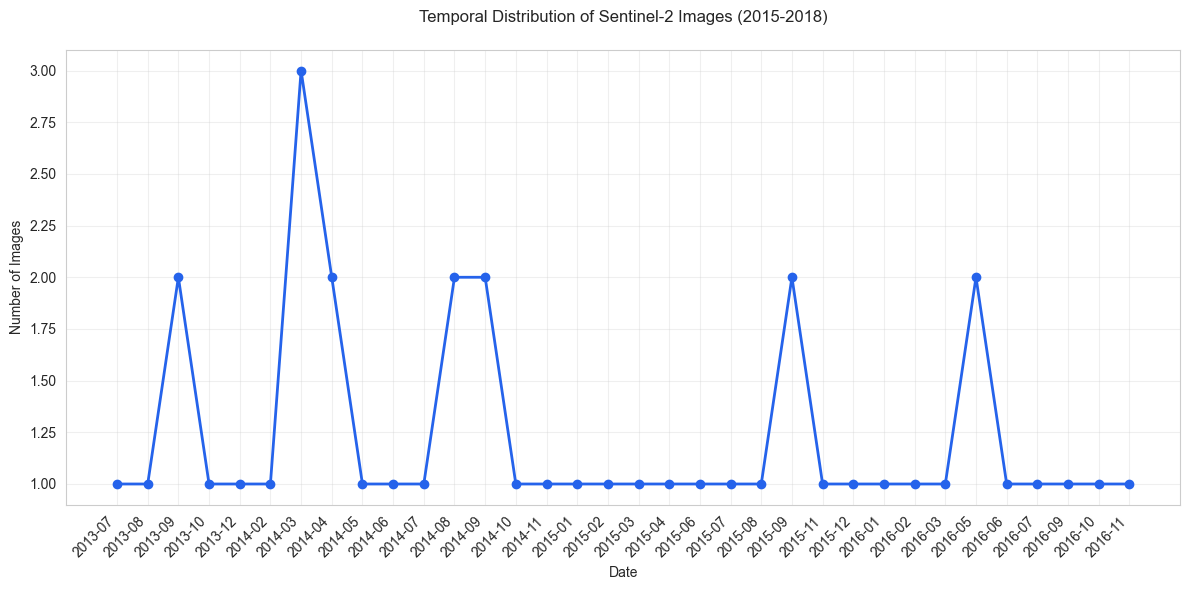

In [54]:
import pandas as pd
from datetime import datetime

def prepare_gee_timeseries(dates):
    """
    Prepare GEE collection dates for time series visualization
    
    Parameters:
    dates: list of datetime objects from GEE collection
    
    Returns:
    dict: Processed data ready for visualization
    """
    # Convert to pandas datetime
    df = pd.DataFrame({'date': dates})
    
    # Create month-year string for grouping
    df['month_year'] = df['date'].dt.strftime('%Y-%m')
    
    # Ensure all months are included (even those with 0 images)
    date_range = pd.date_range(start='2015-01-01', end='2018-01-01', freq='MS')
    all_months = pd.DataFrame({'month_year': date_range.strftime('%Y-%m')})
    
    # Count images per month
    monthly_counts = df['month_year'].value_counts().reset_index()
    monthly_counts.columns = ['month_year', 'count']
    
    # Merge with all months to include zeros
    complete_counts = all_months.merge(monthly_counts, on='month_year', how='left')
    complete_counts['count'] = complete_counts['count'].fillna(0)
    
    # Sort by date
    complete_counts = complete_counts.sort_values('month_year')
    
    return {
        'dates': complete_counts['month_year'].tolist(),
        'counts': complete_counts['count'].tolist()
    }

# Process your GEE dates
timeseries_data = prepare_gee_timeseries(dates)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def plot_image_timeseries(dates):
    """
    Create a time series plot of satellite image acquisitions
    
    Parameters:
    dates: list of datetime objects from GEE collection
    """
    # Convert dates to pandas DataFrame
    df = pd.DataFrame({'date': dates})
    
    # Create month-year for grouping
    df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
    
    # Count images per month
    monthly_counts = df.groupby('month_year').size().reset_index(name='count')
    monthly_counts['month_year'] = monthly_counts['month_year'].astype(str)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Plot the line
    plt.plot(range(len(monthly_counts)), monthly_counts['count'], 
             marker='o', linestyle='-', linewidth=2, markersize=6,
             color='#2563eb')
    
    # Customize the plot
    plt.title('Temporal Distribution of Sentinel-2 Images (2015-2018)', 
             fontsize=12, pad=20)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Number of Images', fontsize=10)
    
    # Set x-axis ticks and labels
    plt.xticks(range(len(monthly_counts)), 
               monthly_counts['month_year'],
               rotation=45,
               ha='right')
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Print statistics
    print("\nTime Series Statistics:")
    print(f"Total number of images: {len(dates)}")
    print(f"Time period: {min(dates).strftime('%Y-%m')} to {max(dates).strftime('%Y-%m')}")
    print(f"Maximum images in one month: {monthly_counts['count'].max()}")
    print(f"Average images per month: {monthly_counts['count'].mean():.2f}")
    
    return plt

# Create and show the plot
plot = plot_image_timeseries(dates)
plt.show()

In [49]:
import ee
import geemap
import ipywidgets as widgets
from IPython.display import HTML

def create_collection_video(collection, vis_params, geometry, fps=3):
    """
    Create a video visualization of an image collection
    
    Parameters:
    -----------
    collection : ee.ImageCollection
        The image collection to visualize
    vis_params : dict
        Visualization parameters for the imagery
    geometry : ee.Geometry
        Region of interest for the video
    fps : int, optional
        Frames per second for the video (default: 2)
    
    Returns:
    --------
    HTML
        HTML widget containing the video player
    """
    # Create a video thumbnail
    video_args = {
        'dimensions': 768,  # Max dimension in pixels
        'region': geometry,
        'framesPerSecond': fps,
        'crs': 'EPSG:3857',
        'format': 'gif'
    }
    
    # Generate video URL
    video_url = collection.map(lambda img: img.visualize(**vis_params)).getVideoThumbURL(video_args)
    
    print(f'Video URL: {video_url}')
    # Create video player widget
    video_widget = HTML(
        f"""
        <video width="100%" controls>
            <source src="{video_url}" type="video/gif">
            Your browser does not support the video tag.
        </video>
        """
    )
    
    return video_widget

# Define visualization parameters
vis_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0,
    'max': 0.3
}

# Create the video
video_player = create_collection_video(
    collection=landsat8,
    vis_params=vis_params,
    geometry=geometry,
    fps=3  # Adjust frames per second as needed
)

# Display the video
#display(video_player)

Video URL: https://earthengine.googleapis.com/v1/projects/ee-sand-engine/videoThumbnails/8934105401a48d446f5f47a737349c89-cecb8a2527fae31c98b3d6c1b2e3cc09:getPixels


In [55]:
# Function to calculate NDWI for Landsat 8
def add_ndwi(image):
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5'])  # Green (B3) and NIR (B5)
    return image.addBands(ndwi.rename('NDWI'))

# Function to calculate MNDWI for Landsat 8
def add_mndwi(image):
    mndwi = image.normalizedDifference(['SR_B3', 'SR_B6'])  # Green (B3) and SWIR (B6)
    return image.addBands(mndwi.rename('MNDWI'))

# Apply NDWI and MNDWI to the collection
ndwi_collection = landsat8.map(add_ndwi)
mndwi_collection = landsat8.map(add_mndwi)

# Get the first image for visualization
first_image = landsat8.first()

# Visualize using geemap
Map = geemap.Map()
Map.addLayer(first_image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3}, "First Image (RGB)")
Map.addLayer(mndwi_collection.first(), {'bands': 'MNDWI', 'min': -0.4, 'max': 1, 'palette': ['red', 'white', 'blue']}, "First Image (MNDWI)")
Map.addLayer(ndwi_collection.first(), {'bands': 'NDWI', 'min': -0.4, 'max': 1, 'palette': ['red', 'white', 'blue']}, "First Image (NDWI)")
Map.addLayer(geometry, {}, "ROI")
Map.centerObject(geometry, 12)
Map

Map(center=[52.05877845186358, 4.180376309936336], controls=(WidgetControl(options=['position', 'transparent_b…